In [1]:
from quests_data import *
from einstein import einstein_crystal

import itertools
from scipy import integrate
from scipy.interpolate import interp1d
from scipy.spatial.distance import cdist
from quests.tools.plotting import savefig
from quests.tools.polyfit import PolynomialRegressor2D

ROOT_DIR = "../data/A11-Cu"

In [2]:
fcc = pd.read_csv(f"{ROOT_DIR}/ti/fcc.csv", index_col=0)
bcc = pd.read_csv(f"{ROOT_DIR}/ti/bcc.csv", index_col=0)

spring_k = 34.148
temperature = 3000
mass = 63.546
GPa = 1 / 160.21766208
kB = 1 / 8.617333e-5

In [3]:
VOLS = [65, 70, 75, 80]
TEMPS = np.arange(3000, 5001, 250)

In [4]:
def integr2(x, y):
    x = np.sqrt(x)
    fn = interp1d(x, 2 * x * y, kind="linear")
    integ, err = integrate.quad(fn, 0.00, 1.00, limit=200)
    return integ

In [5]:
results = []
for (v, t) in itertools.product(VOLS, TEMPS):
    _f = fcc.loc[(fcc.folder == v) & (fcc.temperature == t)] 
    _b = bcc.loc[(bcc.folder == v) & (bcc.temperature == t)] 
    f_ein, u_ein, s_ein = einstein_crystal(spring_k=spring_k, temperature=t, mass=mass)
    
    f_fcc = integr2(_f["lambda"], -_f["energy"] + u_ein)
    f_bcc = integr2(_b["lambda"], -_b["energy"] + u_ein)
    
    results.append({
        "T": t,
        "V": v / 10,
        "U_fcc": _f["energy"].iloc[0],
        "U_bcc": _b["energy"].iloc[0],
        "F_ein": f_ein,
        "S_ein": kB * s_ein,
        "U_ein": u_ein,
        "F_fcc": -f_fcc + f_ein,
        "F_bcc": -f_bcc + f_ein,
        "P_fcc": _f["pressure"].iloc[0],
        "P_bcc": _b["pressure"].iloc[0],
    })
    
df = pd.DataFrame(results)

/var/folders/pk/bysbkx9j3993c_vqdsykcn680000gn/T/ipykernel_45440/1792693385.py:4: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integ, err = integrate.quad(fn, 0.00, 1.00, limit=200)


In [6]:
df["S_fcc"] = -df["F_fcc"].diff().values.reshape(-1, 1) / df["T"].diff().values.reshape(-1, 1) * kB
df["S_bcc"] = -df["F_bcc"].diff().values.reshape(-1, 1) / df["T"].diff().values.reshape(-1, 1) * kB
df["dS"] = df["S_bcc"] - df["S_fcc"]

## Interpolating the free energy

In [7]:
degree = 3
sdf = []

_t = np.arange(2999, 5001, 1)

for v, grp in df.groupby("V"):
    fn_a = PolynomialRegressor2D(degree, grp[["T"]].values, grp["F_fcc"].values)
    fn_b = PolynomialRegressor2D(degree, grp[["T"]].values, grp["F_bcc"].values)
    
    _fa = fn_a(_t.reshape(-1, 1))
    _fb = fn_b(_t.reshape(-1, 1))
    
    _sa = - np.diff(_fa) / np.diff(_t) * kB
    _sb = - np.diff(_fb) / np.diff(_t) * kB
    
    for i, temp in enumerate(_t[1:]):
        sdf.append({
            "T": temp,
            "V": v,
            "S_fcc": _sa[i],
            "S_bcc": _sb[i],
            "dS": _sa[i] - _sb[i],
        })
        
sdf = pd.DataFrame(sdf)

/opt/homebrew/Caskroom/miniconda/base/envs/quests/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.416e-04, tolerance: 4.410e-04
  model = cd_fast.enet_coordinate_descent(
/opt/homebrew/Caskroom/miniconda/base/envs/quests/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.295e-04, tolerance: 4.471e-04
  model = cd_fast.enet_coordinate_descent(


## Comparing BCC and FCC at NVT

In [8]:
sf = pd.read_csv(f"{ROOT_DIR}/entropy-nvt/fcc.csv", index_col=0).pivot(index="temperature", columns="folder", values="entropy")
sb = pd.read_csv(f"{ROOT_DIR}/entropy-nvt/bcc.csv", index_col=0).pivot(index="temperature", columns="folder", values="entropy")

In [9]:
dS = sb - sf
dS.columns = [v / 10 for v in dS.columns]

In [10]:
TEMPS = np.arange(3250, 5001, 250)

true = sdf.loc[sdf["T"].isin(TEMPS)].pivot(index="T", values="dS", columns="V")
true2 = df.loc[df["T"].isin(TEMPS)].pivot(index="T", values="dS", columns="V")

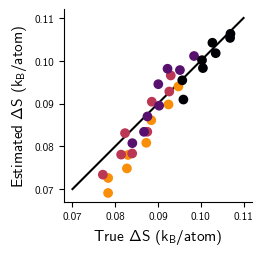

In [11]:
fig, ax = plt.subplots(figsize=(2.5, 2.5))

pred = dS.drop(3000)

norm = plt.Normalize(6.5, 8.5)
cmap = lambda x: cm.inferno(norm(x))

cols = (pred.columns.values.reshape(1, -1) * np.ones_like(pred.values)).reshape(-1)
ax.scatter(
    true2.values.reshape(-1),
    pred.values.reshape(-1),
    c=cmap(cols)
)

lims = np.array([0.07, 0.11])
ax.plot(lims, lims, "k-", zorder=-1)

ax.set_aspect("equal")

ax.set_xlabel("True $\Delta$S (k$_B$/atom)", fontsize=11)
ax.set_ylabel("Estimated $\Delta$S (k$_B$/atom)", fontsize=11)

# savefig(fig, "02-Cu-dS.pdf")
plt.show()